In [1]:
from PIL import Image, ImageDraw
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


import torch
import torchvision
from torch import nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.metrics import accuracy_score

In [2]:
def read_zip(zipfile_str):
    """this function will taked a zipfile and return a list of image"""
    imgzip = zipfile.ZipFile(zipfile_str)
    inflist = imgzip.infolist()
    image_list =[]
    
    for f in inflist:
        ifile = imgzip.open(f)
        img = Image.open(ifile)
        image_list.append(img)
        
    return image_list

In [3]:
def diget_list(images):
    """
    this function take an image and corp it to 9 smal images,
    it return a list of images
    """
    image = images.save('images.png')
    image = images.resize((int(1500),int(1500)))

    x = 0
    y = 0
    h = 500
    w = 500
    image_list = []
    for i in range(9):
        diget_image=image.crop((x,y,x+w,y+h))
        if x+w >= image.width:
            x = 0
            y = y + h
        else:
            x=x+500
        diget_image = diget_image.resize((int(28),int(28)))
        image_list.append(diget_image)
    return image_list

In [4]:
images = read_zip('IMG_diget.zip') # get a listof the images
final_image_list =[]
for image in images: # a for loop to get the 90 image in one list 
    image_list = diget_list(image)
    final_image_list = final_image_list + image_list

# creat a dataframe of the list
image_dataFrame = pd.DataFrame(data =final_image_list, columns =['images'])

In [5]:
# creat a list of the label
g = 0
n = 0
label_list =[]
for i in range(100):
    if g < 9:
        label_list.append(n)
        g = g+1
    else:
        n = n+1
        g = 0
# add the label column
image_dataFrame['Label'] = label_list   

In [6]:
#  shuffle your dataframe
image_dataFrame = image_dataFrame.sample(frac=1, random_state=42).reset_index(drop=True)

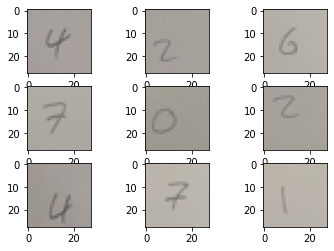

In [7]:
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(image_dataFrame['images'][i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

#### transform image to Tensors of normalized range.

In [14]:
X=[]
y=[]
for i in image_dataFrame['images']:
    i = i.convert('L')
    X.append(np.array(i))

for i in image_dataFrame['Label']:
    y.append(i)

In [15]:
type(X)

list

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size= 0.2)

In [17]:
# convert image aray to tourch.tensor
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
Y_train = torch.Tensor(Y_train)
Y_test = torch.Tensor(Y_test)

In [19]:
# reshaping the data to fit the model
X_train = X_train.reshape(72, 1, 28, 28)
X_test = X_test.reshape(18, 1, 28, 28)

In [20]:
print(f"X_train type is {type(X_train)}, y_train type is {type(Y_train)}")
print(f"X_test type is {type(X_test)}, y_test type is {type(Y_test)}")

X_train type is <class 'torch.Tensor'>, y_train type is <class 'torch.Tensor'>
X_test type is <class 'torch.Tensor'>, y_test type is <class 'torch.Tensor'>


### Define and intialize the neural network

In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1),
        )

        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

        # First fully connected layer
        self.fc1 = nn.Linear(9216, 128)
        # Second fully connected layer
        self.fc2 = nn.Linear(128, 10)
        
        
    def forward(self, x):
        # Pass data through conv1
        x = self.layer1(x)
        # Use the ReLU activation function
        x = F.relu(x)
        # Pass data through conv2
        x = self.layer2(x)
        x = F.relu(x)
        # Run max pooling over x
        x = F.max_pool2d(x, 2)
        # Pass data through dropout1
        x = self.dropout1(x)
        x = self.dropout2(x)
        # Flatten x with start_dim=1
        x = torch.flatten(x, 1)
        # Pass data through fc1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        # Apply softmax to x
        output = F.log_softmax(x, dim=1)
        return output
    

In [22]:
model = Net()
print(model)

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


#### Define a Loss function and optimizer

In [23]:
# defining the loss function
criterion = nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

# defining the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)    

#### Train the network

In [24]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(X_train), Variable(Y_train)
    # getting the validation set
    x_val, y_val = Variable(X_test), Variable(Y_test)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    y_train = y_train.type(torch.LongTensor).cuda()
    y_val = y_val.type(torch.LongTensor).cuda()
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [25]:
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(21.0995, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  3 	 loss : tensor(6.1148, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  5 	 loss : tensor(2.4630, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  7 	 loss : tensor(2.2677, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  9 	 loss : tensor(2.2910, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  11 	 loss : tensor(2.3190, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  13 	 loss : tensor(2.4455, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  15 	 loss : tensor(2.3241, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  17 	 loss : tensor(2.3151, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  19 	 loss : tensor(2.3206, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  21 	 loss : tensor(2.2917, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  23 	 loss : tensor(2.2963, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  25 	 loss : tensor(2.29

In [26]:
train_losses_values = []
val_losses_values = []
for i in train_losses:
    train_losses_values.append(i.item())
for i in val_losses:
    val_losses_values.append(i.item())

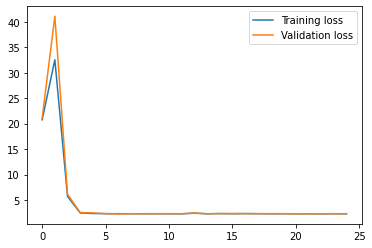

In [27]:
# plotting the training and validation loss
plt.plot(train_losses_values, label='Training loss')
plt.plot(val_losses_values, label='Validation loss')
plt.legend()
plt.show()

#### check the accuracy of the model

In [28]:
# prediction for training set
with torch.no_grad():
    output = model(X_train.cuda())
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
accuracy_score(Y_train, predictions)

0.1388888888888889

In [29]:
# prediction for validation set
with torch.no_grad():
    output = model(X_test.cuda())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on validation set
accuracy_score(Y_test, predictions)

0.05555555555555555